# Foundation Model para o Fine-tuning

Para resolver o challenge da fase 3, foi escolhido a OpenAi como foundation model. A escolha se baseia no fato da autora já ter uma conta ativa lá e créditos para usar, além do fato de poder seguir a ideia apresentada em aula e aprender com uma documentação diferente do Lhama que foi o FM utilizado em aula.

Documentação utilizada para o fine-tuning: 
- https://platform.openai.com/docs/guides/fine-tuning
- https://cookbook.openai.com/examples/how_to_finetune_chat_models
- https://cookbook.openai.com/examples/chat_finetuning_data_prep

# Preparação e Upload dos dados

## Avaliação dos dados

In [4]:
import pandas as pd

def read_json(path: str):
    chunksize = 100
    consultas = pd.read_json(path, lines=True, chunksize=chunksize)

    for chunk in consultas:
        print(chunk.head(10))
        break
    
    return
read_json("base-desafio/trn.json")

          uid                                              title  \
0  0000031909                        Girls Ballet Tutu Neon Pink   
1  0000032034                           Adult Ballet Tutu Yellow   
2  0000913154  The Way Things Work: An Illustrated Encycloped...   
3  0001360000                                      Mog's Kittens   
4  0001381245                              Misty of Chincoteague   
5  0001371045  Hilda Boswell's treasury of children's stories...   
6  0000230022  The Simple Truths of Service: Inspired by John...   
7  0000031895                        Girls Ballet Tutu Neon Blue   
8  0000174076  Evaluating Research in Academic Journals - A P...   
9  0001713086  Dr. Seuss ABC (Dr.Seuss Classic Collection) (S...   

                                             content  \
0  High quality 3 layer ballet tutu. 12 inches in...   
1                                                      
2                                                      
3  Judith Kerr&#8217;s best

Após ver os primeiros dados do json, é possível notar que possui informações além do `title` e `content` que são informações o que queremos usar para o nosso fine-tuning. Portanto, precisamos limpar o arquivo para trabalharmos apenas com as colunas que queremos.

## Limpeza dos dados

In [ ]:
import json

def limpar_json(arquivo_entrada, arquivo_saida):
    try:
        with open(arquivo_entrada, 'r') as entrada, open(arquivo_saida, 'w') as saida:
            for linha in entrada:
                try:
                    dado = json.loads(linha)
                    dado_limpo = {'title': dado['title'], 'content': dado['content']}
                    json.dump(dado_limpo, saida)
                    saida.write('\n')
                except json.JSONDecodeError:
                    print(f"Erro ao decodificar JSON na linha: {linha}")

        print(f"Arquivo limpo salvo em: {arquivo_saida}")

    except Exception as e:
        print(f"Ocorreu um erro: {e}")


limpar_json("base-desafio/trn.json", "base-desafio/trn_limpo.json")

Arquivo limpo salvo em: base-desafio/trn_limpo.json


In [5]:
read_json("base-desafio/trn_limpo.json")

                                               title  \
0                        Girls Ballet Tutu Neon Pink   
1                           Adult Ballet Tutu Yellow   
2  The Way Things Work: An Illustrated Encycloped...   
3                                      Mog's Kittens   
4                              Misty of Chincoteague   
5  Hilda Boswell's treasury of children's stories...   
6  The Simple Truths of Service: Inspired by John...   
7                        Girls Ballet Tutu Neon Blue   
8  Evaluating Research in Academic Journals - A P...   
9  Dr. Seuss ABC (Dr.Seuss Classic Collection) (S...   

                                             content  
0  High quality 3 layer ballet tutu. 12 inches in...  
1                                                     
2                                                     
3  Judith Kerr&#8217;s best&#8211;selling adventu...  
4                                                     
5                                                    

Com o json limpo e considerando apenas o `title` e `content`, fica mais fácil perceber que temos informações sem o `content`. Aqui poderíamos incluir que quando o `content` for vazio, o agente retorne algo como "Não tenho informações sobre esse produto", mas para evitar que ele passe a relacionar determinadas palavras com esse padrão de resposta, vamos limpar a base removendo as linhas com content vazio.

In [6]:
def limpar_json_e_remover_vazios(arquivo_entrada, arquivo_saida):
    try:
        with open(arquivo_entrada, 'r') as entrada, open(arquivo_saida, 'w') as saida:
            for linha in entrada:
                try:
                    dado = json.loads(linha)
                    if dado['content'] != '':  # Verifica se 'content' não está vazio
                        dado_limpo = {'title': dado['title'], 'content': dado['content']}
                        json.dump(dado_limpo, saida)
                        saida.write('\n')
                except json.JSONDecodeError:
                    print(f"Erro ao decodificar JSON na linha: {linha}")

        print(f"Arquivo limpo e linhas vazias removidas, salvo em: {arquivo_saida}")

    except Exception as e:
        print(f"Ocorreu um erro: {e}")


limpar_json_e_remover_vazios("base-desafio/trn_limpo.json", "base-desafio/trn_limpo_sem_vazios.json")

Arquivo limpo e linhas vazias removidas, salvo em: base-desafio/trn_limpo_sem_vazios.json


In [7]:
read_json("base-desafio/trn_limpo_sem_vazios.json")

                                               title  \
0                        Girls Ballet Tutu Neon Pink   
1                                      Mog's Kittens   
2                        Girls Ballet Tutu Neon Blue   
3                                        The Prophet   
4                          Rightly Dividing the Word   
5                        Worship with Don Moen [VHS]   
6                         Autumn Story Brambly Hedge   
7  Spirit Led-Moving By Grace In The Holy Spirit'...   
8               The Very Bad Bunny (Beginner Series)   
9                                      Nice for Mice   

                                             content  
0  High quality 3 layer ballet tutu. 12 inches in...  
1  Judith Kerr&#8217;s best&#8211;selling adventu...  
2  Dance tutu for girls ages 2-8 years. Perfect f...  
3  In a distant, timeless place, a mysterious pro...  
4         --This text refers to thePaperbackedition.  
5                        Worship with Don Moen [VHS] 

## Preparação

Agora com os dados limpos e devidamente preenchidos, faremos uma validação desse dataset para ver uma pequena prévia de como ele vai se comportar no processo de pergunta e respostas.

In [ ]:
import json

def ler_primeiras_n_linhas_json(n: int) -> list:
    dados = []
    try:
        with open("base-desafio/trn_limpo_sem_vazios.json", "r") as f:
            for i, linha in enumerate(f):
                if i >= n:
                    break
                try:
                    dado = json.loads(linha)
                    dados.insert(i, dado)
                except json.JSONDecodeError:
                    print(f"Erro ao decodificar JSON na linha: {linha}")
        return dados
    except Exception as e:
        print(f"Ocorreu um erro: {e}")
        return None

In [85]:
system_message = "You are a helpful product assistant. You are to answer the title of the product from each of the questions provided."

def cria_pergunta_usuario(row):
    return f"Question: {row['content']}"


def prepara_exemplo_conversa(row):
    return {
        "messages": [
            {"role": "system", "content": system_message},
            {"role": "user", "content": cria_pergunta_usuario(row)},
            {"role": "assistant", "content": row["title"]},
        ]
    }


df = pd.DataFrame(ler_primeiras_n_linhas_json(500))
print(prepara_exemplo_conversa(df.iloc[0]))

{'messages': [{'role': 'system', 'content': 'You are a helpful product assistant. You are to answer the title of the product from each of the questions provided.'}, {'role': 'user', 'content': 'Question: High quality 3 layer ballet tutu. 12 inches in length'}, {'role': 'assistant', 'content': 'Girls Ballet Tutu Neon Pink'}]}


Pela própria [documentação de fine-tuning da OpenAi](https://platform.openai.com/docs/guides/fine-tuning#example-count-recommendations), o ideal é fornecer entre 50 e 100 exemplos para o `gpt-4o-mini` e o `gpt-3.5-turbo`, como iremos usar o 4o mini, faremos uma base com 100 exemplos como o criado anteriormente

In [54]:
df_treino = df.loc[0:100]

dados_treino = df_treino.apply(prepara_exemplo_conversa, axis=1).tolist()

for exemplo in dados_treino[:5]:
    print(exemplo)

{'messages': [{'role': 'system', 'content': 'You are a helpful product assistant. You are to answer the title of the product from each of the questions provided.'}, {'role': 'user', 'content': 'Question: High quality 3 layer ballet tutu. 12 inches in length'}, {'role': 'assistant', 'content': 'Girls Ballet Tutu Neon Pink'}]}
{'messages': [{'role': 'system', 'content': 'You are a helpful product assistant. You are to answer the title of the product from each of the questions provided.'}, {'role': 'user', 'content': 'Question: Judith Kerr&#8217;s best&#8211;selling adventures of that endearing (and exasperating) cat Mog have entertained children for more than 30 years. Now, even infants and toddlers can enjoy meeting this loveable feline. These sturdy little board books&#8212;with their bright, simple pictures, easy text, and hand&#8211;friendly formats&#8212;are just the thing to delight the very young. Ages 6 months&#8211;2 years.'}, {'role': 'assistant', 'content': "Mog's Kittens"}]}


In [57]:
df_validacao = df.loc[101:200]
dados_validacao = df_validacao.apply(prepara_exemplo_conversa, axis=1).tolist()

Agora vamos criar os arquivos de exemplo tanto de treino como de validação em jsonl

In [55]:
def cria_jsonl(lista: list, arquivo: str) -> None:
    with open(arquivo, "w") as out:
        for dado in lista:
            saida = json.dumps(dado) + "\n"
            out.write(saida)

In [58]:
nome_arquivo_treino = "base-desafio/tmp_produto_finetune_treino.jsonl"
cria_jsonl(dados_treino, nome_arquivo_treino)

nome_arquivo_validacao = "base-desafio/tmp_produto_finetune_validacao.jsonl"
cria_jsonl(dados_validacao, nome_arquivo_validacao)

## Upload dos dados

Agora que temos os dados limpos e tratados, os arquivos de treino e validação, vamos fazer o import deles para o início do fine-tuning na plataforma da OpenAi, conforme documentação: https://platform.openai.com/docs/guides/fine-tuning#upload-a-training-file

In [60]:
import openai
import os

client = openai.OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

def upload(arquivo: str, tipo: str) -> str:
    with open(arquivo, "rb") as file_fd:
        response = client.files.create(file=file_fd, purpose=tipo)
    return response.id


id_arquivo_treino = upload(nome_arquivo_treino, "fine-tune")
id_arquivo_validacao = upload(nome_arquivo_validacao, "fine-tune")

print("ID arquivo de treino:", id_arquivo_treino)
print("ID arquivo de validacao:", id_arquivo_validacao)

ID arquivo de treino: file-Da51br7qwa613EmWLv6XUL
ID arquivo de validacao: file-4ECiqVgnCpq5k2usCMQ2dh


# Fine-tuning

## Criação do fine-tunning

In [61]:
MODELO = "gpt-4o-mini-2024-07-18"

response = client.fine_tuning.jobs.create(
    training_file=id_arquivo_treino,
    validation_file=id_arquivo_validacao,
    model=MODELO,
    suffix="produtos-amazon",
)

job_id = response.id

print("Job ID:", response.id)
print("Status:", response.status)

Job ID: ftjob-sKt0xQxtnIPCeX8nQgecYcJS
Status: validating_files


### Fine-tuning em andamento

Processamento em andamento

![Captura de tela 2025-03-16 110959.png](<attachment:Captura de tela 2025-03-16 110959.png>)
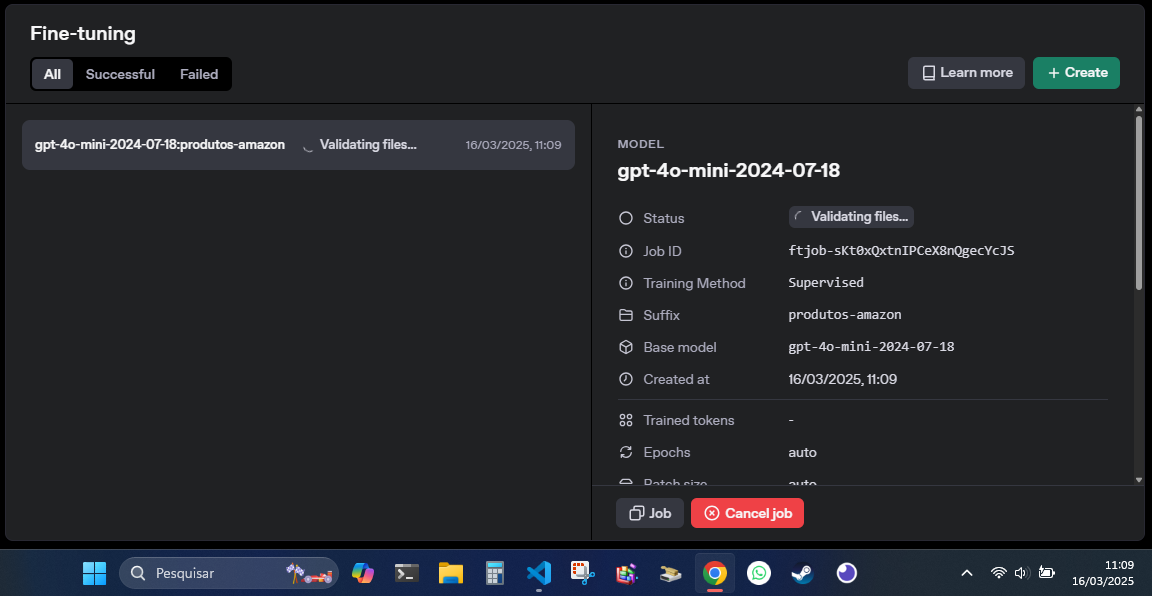

Processamento concluído com sucesso

![Captura de tela 2025-03-16 113050.png](<attachment:Captura de tela 2025-03-16 113050.png>)
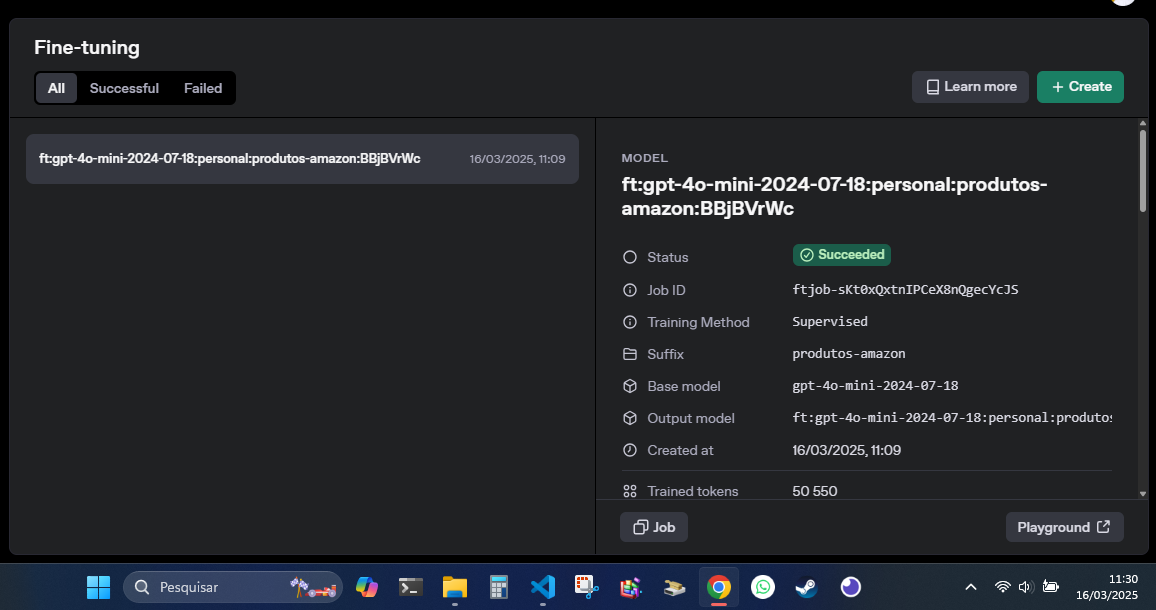

In [63]:
response = client.fine_tuning.jobs.retrieve(job_id)

print("Job ID:", response.id)
print("Status:", response.status)
print("Tokens treinados:", response.trained_tokens)

Job ID: ftjob-sKt0xQxtnIPCeX8nQgecYcJS
Status: succeeded
Tokens treinados: 50550


In [ ]:
response = client.fine_tuning.jobs.list_events(job_id)

events = response.data
events.reverse()

for event in events:
    print(event.message)

Step 288/303: training loss=0.65
Step 289/303: training loss=0.00
Step 290/303: training loss=0.69, validation loss=1.82
Step 291/303: training loss=1.39
Step 292/303: training loss=1.56
Step 293/303: training loss=0.36
Step 294/303: training loss=0.85
Step 295/303: training loss=0.42
Step 296/303: training loss=0.02
Step 297/303: training loss=0.01
Step 298/303: training loss=0.00
Step 299/303: training loss=0.00
Step 300/303: training loss=0.00, validation loss=0.37
Step 301/303: training loss=0.28
Step 302/303: training loss=0.56
Step 303/303: training loss=0.30, validation loss=0.01, full validation loss=1.46
Checkpoint created at step 101
Checkpoint created at step 202
New fine-tuned model created
The job has successfully completed


In [88]:
response = client.fine_tuning.jobs.retrieve(job_id)
fine_tuned_model_id = response.fine_tuned_model

if fine_tuned_model_id is None:
    raise RuntimeError(
        "Fine-tuned model ID não encontrado. Seu job pode não ter terminado ainda."
    )

print("Fine-tuned model ID:", fine_tuned_model_id)

Fine-tuned model ID: ft:gpt-4o-mini-2024-07-18:personal:produtos-amazon:BBjBVrWc


## Teste de inferência

In [113]:
df_teste = df.loc[201:300]
linha_teste = df_teste.iloc[0]
mensagens_teste = []
mensagens_teste.append({"role": "system", "content": system_message})
user_message = cria_pergunta_usuario(linha_teste)
mensagens_teste.append({"role": "user", "content": user_message})

print(mensagens_teste)

[{'role': 'system', 'content': 'You are a helpful product assistant. You are to answer the title of the product from each of the questions provided.'}, {'role': 'user', 'content': "Question: Praise for the Paddington series: 'I've always had great respect for Paddington... He is a British institution.' Stephen Fry 'Paddington has joined Pooh as one of the great bears of English children's literature.' The Teacher 'Michael Bond's accident-prone bear...has become one of the most enduring of children's characters.' The Bookseller"}]


In [97]:
response = client.chat.completions.create(
    model=fine_tuned_model_id, messages=mensagens_teste, temperature=0, max_tokens=500
)
print(response.choices[0].message.content)

Paddington: The Original Stories
